# Data preperation

The scraped images are processed to create left-rotated, right-rotated, upside-down, negative colour and red tinted versions of the images.

### Imports

In [5]:
import os
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image, ImageOps, ImageEnhance
from pathlib import Path
import imagesize
import numpy as np
import random
import itertools
import random

### Resolution of the images

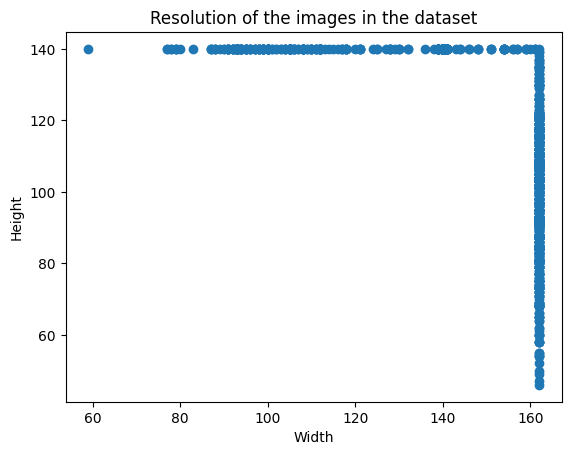

In [3]:
# get the image resolution of all the images in the raw folder
raw_folder = Path("../data/raw")
image_resolutions = []
for image_path in raw_folder.glob("*.jpg"):
    with Image.open(image_path) as image:
        width, height = image.size
        image_resolutions.append((width, height))

# convert the list of tuples to a pandas dataframe
df = pd.DataFrame(image_resolutions, columns=["width", "height"])

# plot the resolution of the images as a scatter plot
plt.scatter(df["width"], df["height"])
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Resolution of the images in the dataset")
plt.show()



Based on the scatter , it appears that the majority of the images have a width of around 160 pixels and a height of around 140 pixels. There is a notable concentration of points at these dimensions, which suggests that many of the images have similar or identical resolutions. For the further course of the project, a size of 128x128 is selected for the images.

### Image preparation

The images are now processed and then stored in the ‘processed’ folder. Labels are also created for the images and saved in a CSV.

In [7]:
from pathlib import Path
import os
from PIL import Image, ImageOps
import pandas as pd
import random

# Input- und Output-Ordner
input_folder = Path("../data/raw")
output_folder = Path("../data/processed")
os.makedirs(output_folder, exist_ok=True)

# List for image labels
image_labels = []

# transformations
transformations = [
    ('original', lambda x: x),
    ('rotated_left', lambda x: x.rotate(90, expand=True)),
    ('rotated_right', lambda x: x.rotate(-90, expand=True)),
    ('upside_down', lambda x: x.rotate(180, expand=True)),
    ('negative', lambda x: ImageOps.invert(x.convert("RGB"))),
    ('red_tint', lambda x: Image.merge('RGB', (
        x.split()[0].point(lambda i: i * random.uniform(1.5, 2.0)),
        x.split()[1].point(lambda i: i * random.uniform(0.5, 0.8)),
        x.split()[2].point(lambda i: i * random.uniform(0.5, 0.8))
    )))
]

# Tranformationnames
transformation_names = [t[0] for t in transformations]

# valid and additional combinations
valid_combinations = [
    ('original', []),
    ('rotated_left', [1]),
    ('rotated_right', [2]),
    ('upside_down', [3]),
    ('negative', [4]),
    ('red_tint', [5]),
]

additional_combinations = [
    ('negative_rotated_left', [1, 4]),
    ('negative_rotated_right', [2, 4]),
    ('negative_upside_down', [3, 4]),
    ('red_tint_rotated_left', [1, 5]),
    ('red_tint_rotated_right', [2, 5]),
    ('red_tint_upside_down', [3, 5]),
]

def save_image(image, transformation, filename, counter):
    # secure that the image is in RGB mode
    if image.mode != 'RGB':
        image = image.convert('RGB')
    save_path = output_folder / f"{filename.stem}_{transformation}_{counter}{filename.suffix}"
    image.save(save_path)
    return save_path.name

def apply_transformations(image_path, counter):
    with Image.open(image_path) as img:
        # change the image resolution to 128x128
        img = img.resize((128, 128))
        # secure that the image is in RGB mode
        if img.mode != 'RGB':
            img = img.convert('RGB')
        filename = image_path.name

        # normal combinations of transformations
        for combo_name, combo_indices in valid_combinations:
            transformed_img = img
            label = [0] * len(transformations)
            if combo_name == 'original':
                label[0] = 1  # 'original' marked as 1
            else:
                for i in combo_indices:
                    transformed_img = transformations[i][1](transformed_img)
                    label[i] = 1

            save_name = save_image(transformed_img, combo_name, image_path, counter)
            image_labels.append([save_name] + label)

        # ciclic combinations of transformations
        index = counter % 4
        if index == 1:
            chosen_combinations = [additional_combinations[0], additional_combinations[3]]
        elif index == 2:
            chosen_combinations = [additional_combinations[1], additional_combinations[4]]
        elif index == 3:
            chosen_combinations = [additional_combinations[2], additional_combinations[5]]
        else:
            chosen_combinations = []

        for combo_name, combo_indices in chosen_combinations:
            transformed_img = img
            label = [0] * len(transformations)
            for i in combo_indices:
                transformed_img = transformations[i][1](transformed_img)
                label[i] = 1

            save_name = save_image(transformed_img, combo_name, image_path, counter)
            image_labels.append([save_name] + label)

counter = 0
for image_path in input_folder.glob("*.jpg"):
    apply_transformations(image_path, counter)
    counter += 1

# convert the list of image labels to a pandas dataframe
columns = ["filename"] + transformation_names
labels_df = pd.DataFrame(image_labels, columns=columns)
labels_df.to_csv(output_folder / "labels.csv", index=False)
print(labels_df.head())

                         filename  original  rotated_left  rotated_right  \
0       airplane_1_original_0.jpg         1             0              0   
1   airplane_1_rotated_left_0.jpg         0             1              0   
2  airplane_1_rotated_right_0.jpg         0             0              1   
3    airplane_1_upside_down_0.jpg         0             0              0   
4       airplane_1_negative_0.jpg         0             0              0   

   upside_down  negative  red_tint  
0            0         0         0  
1            0         0         0  
2            0         0         0  
3            1         0         0  
4            0         1         0  


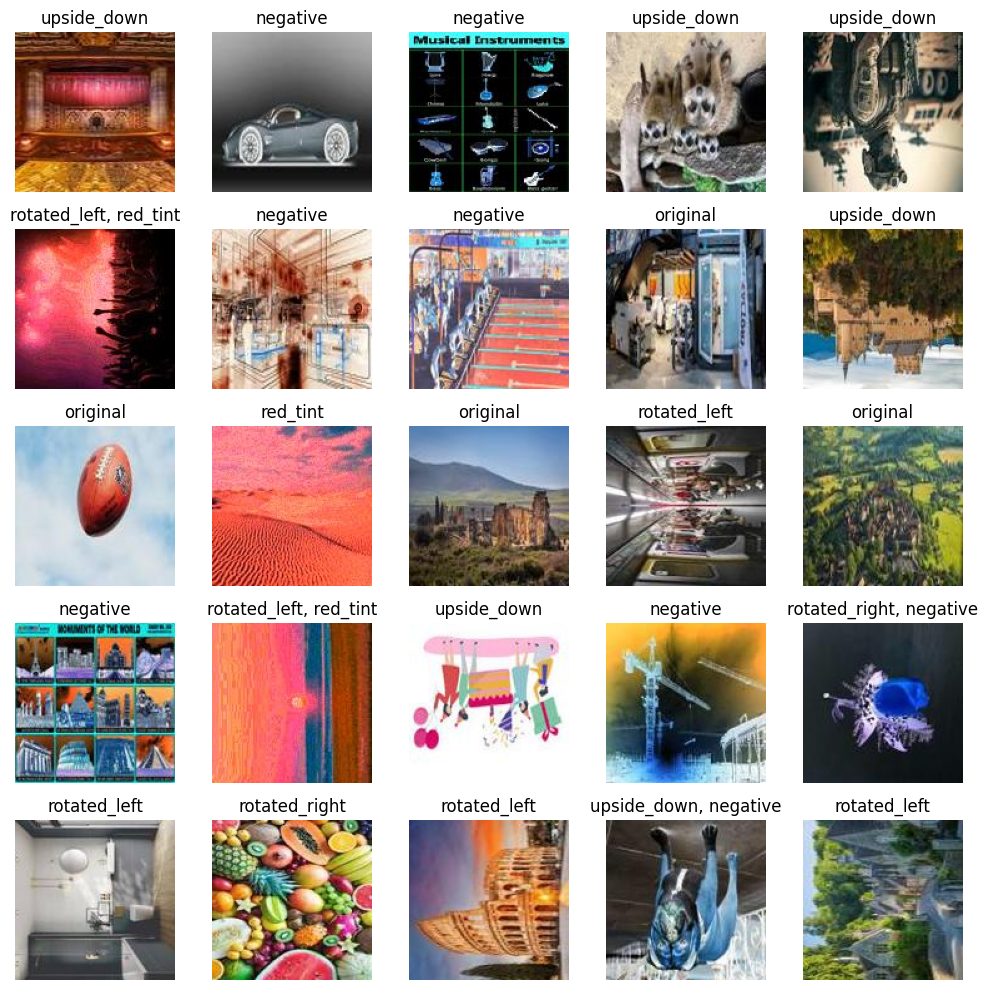

In [8]:
# plot 25 images from the processed folder in a 5x5 grid with their labels which are in the csv file in the processed folder
processed_folder = Path("../data/processed")
image_paths = list(processed_folder.glob("*.jpg"))
random_image_paths = random.sample(image_paths, 25)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, image_path in enumerate(random_image_paths):
    with Image.open(image_path) as img:
        row = i // 5
        col = i % 5
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        # Get the labels from the csv file which is in the processed folder. An image can have multiple labels
        labels = labels_df[labels_df["filename"] == image_path.name].iloc[0]
        title = ", ".join([name for name, label in zip(transformation_names, labels[1:]) if label == 1])
        axes[row, col].set_title(title)
plt.tight_layout()
plt.show()

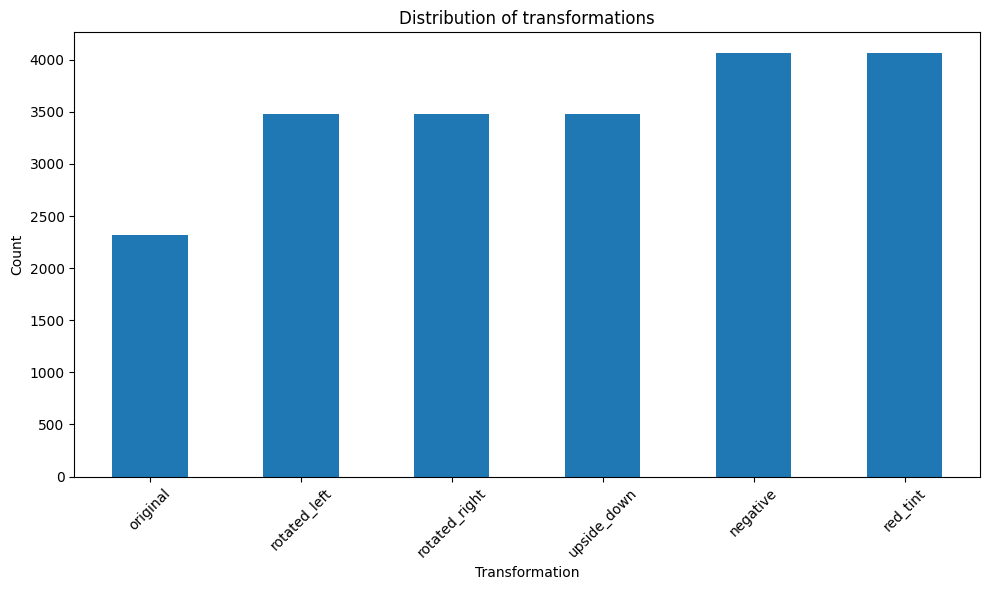

In [9]:
# plot the distribution of the labels in the csv file in the processed folder. An image can have multiple labels
label_counts = labels_df.iloc[:, 1:].sum()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of transformations')
plt.xlabel('Transformation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()